 (Full) Gradient Descent (GD)
• Stochastic Gradient Descent (SGD)
• SGD with Momentum (SGDM)
• Adaptive Gradient (AdaGrad)
• RMSProp
• AdaDelta
• Adaptive Momentum (ADAM)

Describe each of the techniques in detail. Compare and contrast the relative advantages and
disadvantages of each of the techniques. Are there specific types of datasets where one technique is expected to perform better than the other? if so, why? Provide detailed justifications
for each.

Datasets: linearly separable and non-separable
https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
https://stackoverflow.com/questions/47961536/how-to-generate-linear-separable-dataset-by-using-sklearn-datasets-make-classifi

1) write logreg
2) write cost functions: 1) linear, 2) log
https://www.internalpointers.com/post/cost-function-logistic-regression
3) finish methods

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [2]:
def split(dataset, y, ratio):
    msk = np.random.rand(len(dataset)) < ratio
    return dataset[msk], dataset[~msk], y[msk], y[~msk]

In [3]:
def logreg(X, theta):
    return 1/(1+np.exp(-(X @ theta)))
              
def log_cost(pred, y):
    n = len(y)
    eps = 0.000001
    return np.sum(y*-1*np.log(pred+eps) - (1-y)*np.log(1-pred+eps))/n
                    
def lin_cost(pred, y):
    n = len(y)
    return np.sum(np.square(pred-y))/(2*n)

def predict(X, theta, y):
    label = np.round(logreg(X, theta))
    print(np.sum(label))
    return np.sum(label == y)/len(y)

In [1058]:
def gd(X, y, eta, n, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    
    for i in range(n):
        #adjust theta
        pred = logreg(X, theta)
        theta = theta - eta * 1/len(y) * (X.T @ (pred-y))
    return theta

def sgd(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)

    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #adjust theta
            pred = logreg(sample_X, theta)
            theta = theta - eta * 1/batch * (sample_X.T @ (pred-sample_y))
            j += batch
    return theta

def sgdm(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get prediction
            pred = logreg(sample_X, theta)

            #if first time, initialize v_{t-1}
            if i == 0 and j == 0:
                theta = theta - eta * 1/batch * (sample_X.T @ (pred-sample_y))
                last_v = theta

            #else, adjust theta
            else:
                last_v = gamma * last_v + eta * 1/len(sample_y) * (sample_X.T @ (pred-sample_y))
                theta = theta - last_v
            j += batch
    return theta

def adagrad(X, y, eta, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    
    G = np.zeros((f, f))
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get prediction
            pred = logreg(sample_X, theta)

            #compute G        
            
            gradient = sample_X.T @ (pred-sample_y)
            diag += gradient**2
            temp_diag = eta/(np.sqrt(diag)+eps)
            np.fill_diagonal(G, temp_diag)

            #compute theta
            theta = theta - G @ gradient
            j+= batch
        
    return theta

def rmsprop(X, y, eta, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_g2 = 0 
    G = np.zeros((f, f))
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

        
            #get predictions and gradients
            pred = logreg(sample_X, theta)

            #compute G       
            G = np.zeros((f, f))
            gradient = sample_X.T @ (pred-sample_y)
            prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2
            temp_diag = eta/(np.sqrt(prev_g2)+eps)
            np.fill_diagonal(G, temp_diag)

            #compute theta
            theta = theta - G @ gradient
        
            j+=batch
    return theta

def adadelta(X, y, gamma, n, batch, log=True):
    #set-up
    f = X.shape[1]
    theta = np.zeros(f)
    diag = np.zeros(f)
    eps = 0.0000001
    prev_e_delta = 0 
    prev_g2 = 0
    prev_delta = 0
    
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

        
            #get predictions and gradients
            pred = logreg(sample_X, theta)

            #compute rms_g
            gradient = sample_X.T @ (pred-sample_y)
            prev_g2 = gamma*prev_g2 + (1-gamma)*gradient**2 
            rms_g = np.sqrt(prev_g2+eps)


            #compute rms_delta
            e_delta = gamma*prev_e_delta+(1-gamma)*prev_delta**2
            prev_e_delta = e_delta
            rms_delta = np.sqrt(e_delta+eps)

            #get weights
            prev_delta = -1*rms_delta/rms_g * gradient
            theta = theta + prev_delta
        
            j += batch
    return theta 

def adam(X, y, eta, n, batch, b_1, b_2, log=True):
    f = X.shape[1]
    theta = np.zeros(f)
    eps = 0.0000001
    m = 0
    v = 0
    
    for i in range(n):
        #shuffle data
        ind = list(range(0, X.shape[0]))
        np.random.shuffle(ind)
        X = X[ind]
        y = y[ind]

        j=0
        
        while ((len(y)-j) > batch):
            sample_X = X[j:j+batch]
            sample_y = y[j:j+batch]

            #get predictions and gradients
            pred = logreg(sample_X, theta)
            gradient = sample_X.T @ (pred-sample_y)

            m = b_1*m+(1-b_1)*gradient
            v = b_2*v+(1-b_2)*(gradient**2)


            m_hat = m/(1-b_1**(n+1))
            v_hat = v/(1-b_2**(n+1))
            theta = theta - eta / (np.sqrt(v_hat) + eps) * m_hat
            j += batch
    return theta

# Get data

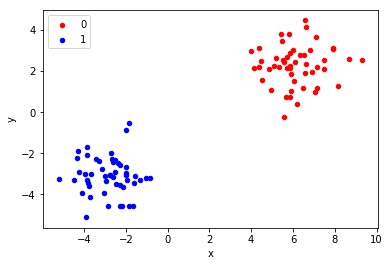

In [1113]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2)
X = np.hstack((np.ones((m,1)),X))
df = pd.DataFrame(dict(x=X[:,1], y=X[:,2], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.show()

In [1114]:
train_X, test_X, train_y, test_y = split(X, y, 0.7)

In [1115]:
eta = 0.2
n = 500
gamma = 0.01
batch = 10
gd_theta = gd(train_X, train_y, eta, n)
# sgd_theta = sgd(train_X, train_y, eta, n, batch)
# sgdm_theta = sgdm(train_X, train_y, eta, gamma, n, batch)
# adagrad_theta = adagrad(train_X, train_y, eta, n, batch)
rmsprop_theta = rmsprop(train_X, train_y, eta, gamma, n, batch)
adadelta_theta = adadelta(train_X, train_y, gamma, n, batch)
# adam_theta = adam(train_X, train_y, gamma, n, batch)
# sgdm_theta
adadelta_theta

array([ 0.68467826, -2.45286512, -1.92224029])

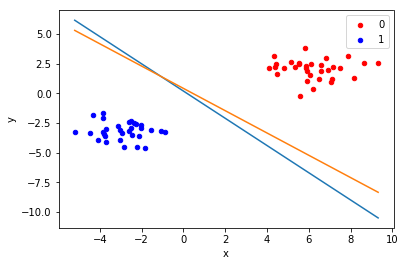

In [1116]:
df = pd.DataFrame(dict(x=train_X[:,1], y=train_X[:,2], label=train_y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

x_p = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
y_p = (-gd_theta[0] -gd_theta[1]* x_p)/gd_theta[2]
# y_p2 = (-sgd_theta[0] -sgd_theta[1]* x_p)/sgd_theta[2]
# y_p3 = (-sgdm_theta[0] -sgdm_theta[1]* x_p)/sgdm_theta[2]
# y_p3 = (-adagrad_theta[0] -adagrad_theta[1]* x_p)/adagrad_theta[2]
y_p3 = (-rmsprop_theta[0] -rmsprop_theta[1]* x_p)/rmsprop_theta[2]
# y_p3 = (-adadelta_theta[0] -adadelta_theta[1]* x_p)/adadelta_theta[2]
# ax.set_ylim((ymin, ymax))
# ax.set_xlim((xmin, xmax))
plt.plot(x_p, y_p)
# plt.plot(x_p, y_p2)
plt.plot(x_p, y_p3)
plt.show()

In [309]:
len(y)

100

In [214]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gradient_descent(X, y, params, learning_rate, iterations):
    m = len(y)
    for i in range(iterations):
        params = params - (learning_rate/m) * (X.T @ (sigmoid(X @ params) - y)) 
    return params


def predict(X, params):
    return np.round(sigmoid(X @ params))

In [217]:

m = len(y)
n = np.size(X,1)
params = np.zeros((n,1))
iterations = 1500
learning_rate = 0.03
params_optimal = gradient_descent(train_X, train_y, params, learning_rate, iterations)

In [218]:
params_optimal

array([[-0.53815316, -0.53815316,  0.53815316, -0.53815316, -0.53815316,
         0.53815316,  0.53815316, -0.53815316, -0.53815316, -0.53815316,
        -0.53815316,  0.53815316,  0.53815316, -0.53815316,  0.53815316,
        -0.53815316, -0.53815316,  0.53815316, -0.53815316, -0.53815316,
        -0.53815316,  0.53815316,  0.53815316,  0.53815316,  0.53815316,
        -0.53815316,  0.53815316,  0.53815316, -0.53815316, -0.53815316,
         0.53815316,  0.53815316, -0.53815316,  0.53815316,  0.53815316,
        -0.53815316, -0.53815316,  0.53815316, -0.53815316, -0.53815316,
        -0.53815316,  0.53815316,  0.53815316,  0.53815316,  0.53815316,
         0.53815316,  0.53815316, -0.53815316, -0.53815316,  0.53815316,
        -0.53815316,  0.53815316, -0.53815316, -0.53815316, -0.53815316,
        -0.53815316, -0.53815316, -0.53815316, -0.53815316, -0.53815316,
         0.53815316, -0.53815316, -0.53815316,  0.53815316,  0.53815316],
       [-0.7377762 , -0.7377762 ,  0.7377762 , -0.